In [59]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [2]:
xmatch = Table.read('/Users/adrian/data/APOGEE_DR15beta/gaiadr2_allStar-t9-l31c-58158.fits')
xmatch.rename_column('apstar_id', 'APSTAR_ID')

In [3]:
apogee = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158.fits')

In [4]:
stream_mask = (apogee['APOGEE2_TARGET1'] & (2**18 + 2**19)) != 0
stream_mask.sum()

1035

In [5]:
apogee_gaia = join(apogee[stream_mask], xmatch, keys='APSTAR_ID')
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]

# select distance stuff
apogee_gaia = apogee_gaia[(apogee_gaia['parallax'] < 1.) | ((apogee_gaia['parallax'] - apogee_gaia['parallax_error']) < 1.)]

g = GaiaData(apogee_gaia)
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


620

In [6]:
np.unique(apogee_gaia['FIELD'])

GD1-1
GD1-2
GD1-3
GD1-4
GD1-5
M67
ORPHAN-1
ORPHAN-2
ORPHAN-3
ORPHAN-4
ORPHAN-5


In [7]:
gd1_mask = np.array(['GD1' in f for f in apogee_gaia['FIELD']])
orp_mask = np.array(['ORPHAN' in f for f in apogee_gaia['FIELD']])
pal5_mask = np.array(['PAL5' in f for f in apogee_gaia['FIELD']])
tri_mask = np.array(['TRIAND' in f for f in apogee_gaia['FIELD']])

gd1_mask.sum(), orp_mask.sum(), pal5_mask.sum(), tri_mask.sum()

(215, 190, 74, 15)

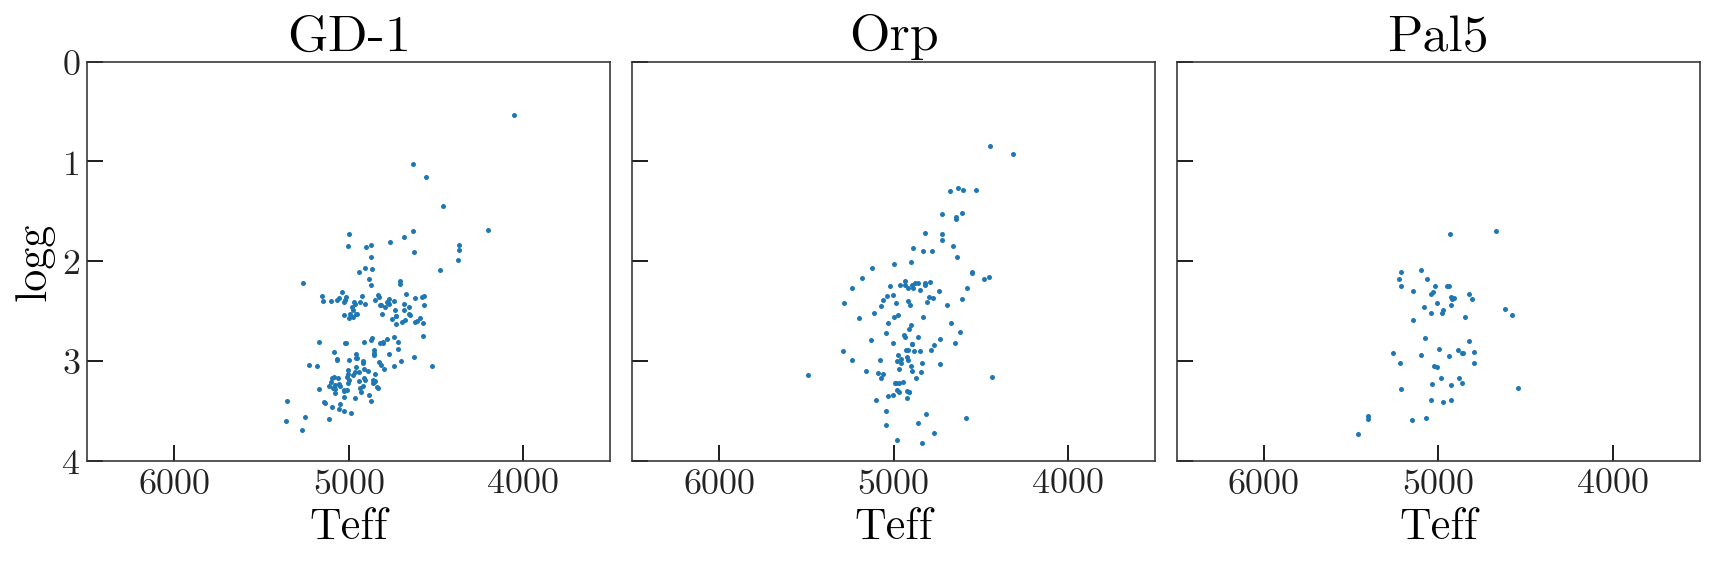

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, name, mask in zip(range(3), 
                         ['GD-1', 'Orp', 'Pal5'],
                         [gd1_mask, orp_mask, pal5_mask]):
    ax = axes.flat[i]
    ax.plot(apogee_gaia['TEFF'][mask], apogee_gaia['LOGG'][mask], 
            marker='.', linestyle='none')
    ax.set_title(name)
    ax.set_xlabel('Teff')

ax.set_xlim(6500, 3500)
ax.set_ylim(4, 0)
axes[0].set_ylabel('logg')

fig.tight_layout()

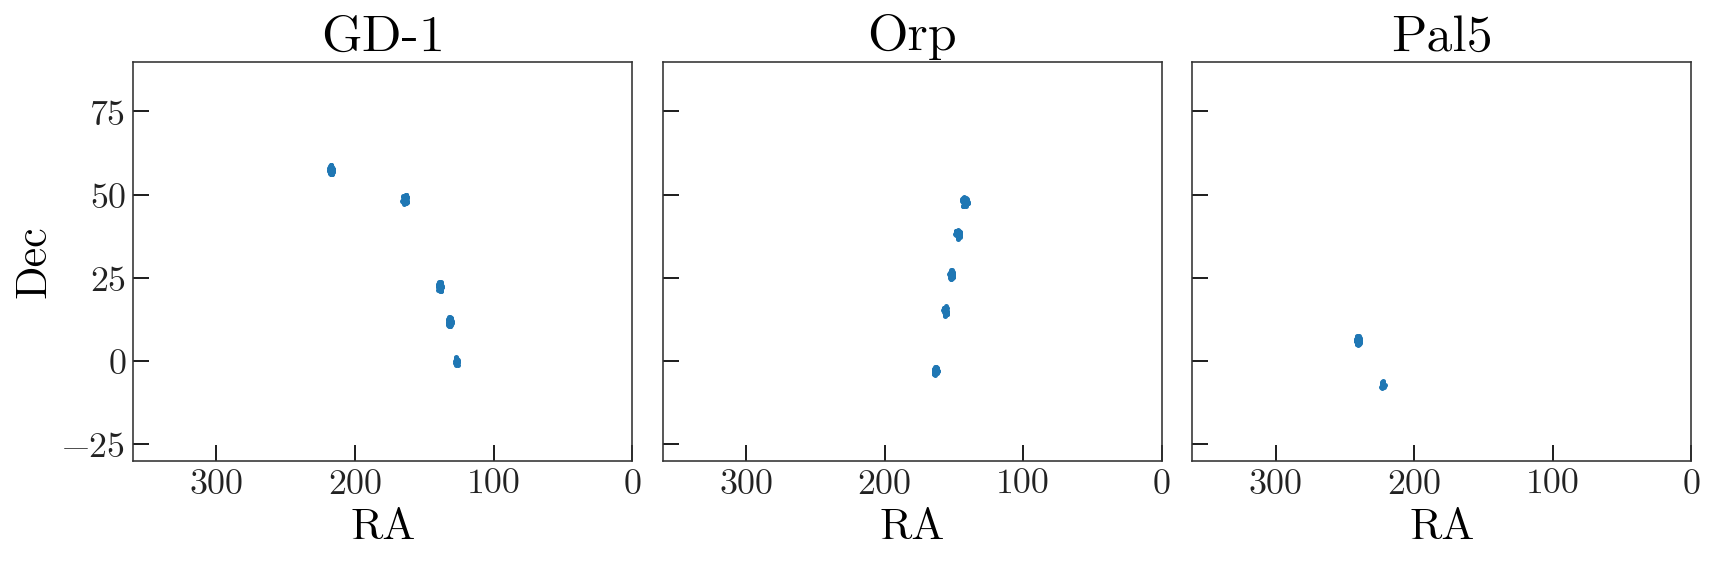

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, name, mask in zip(range(3), 
                         ['GD-1', 'Orp', 'Pal5'],
                         [gd1_mask, orp_mask, pal5_mask]):
    ax = axes.flat[i]
    ax.plot(apogee_gaia['RA'][mask], apogee_gaia['DEC'][mask], 
            marker='.', linestyle='none')
    ax.set_title(name)
    ax.set_xlabel('RA')

fig.tight_layout()
ax.set_xlim(360, 0)
ax.set_ylim(-30, 90)
axes[0].set_ylabel('Dec')

fig.tight_layout()

In [56]:
pm_poly = np.load('../../gd1-dr2/output/pm_poly.npy')

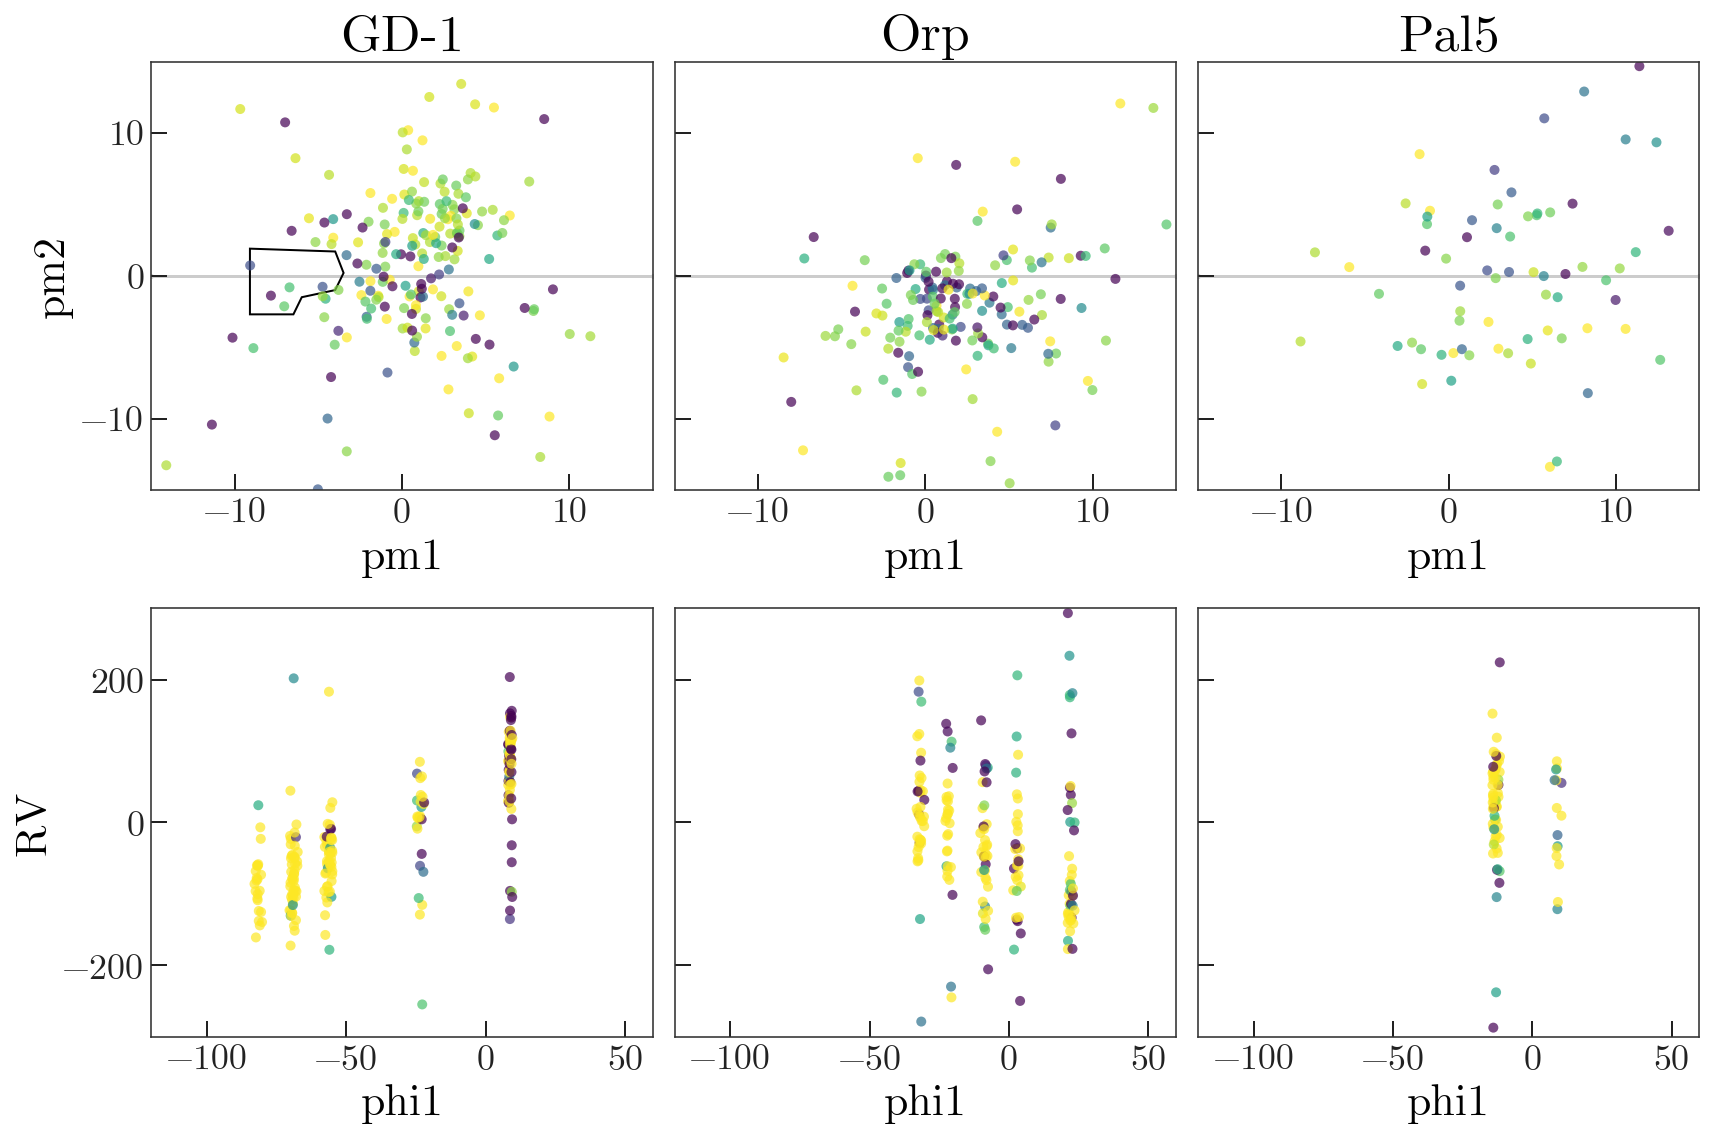

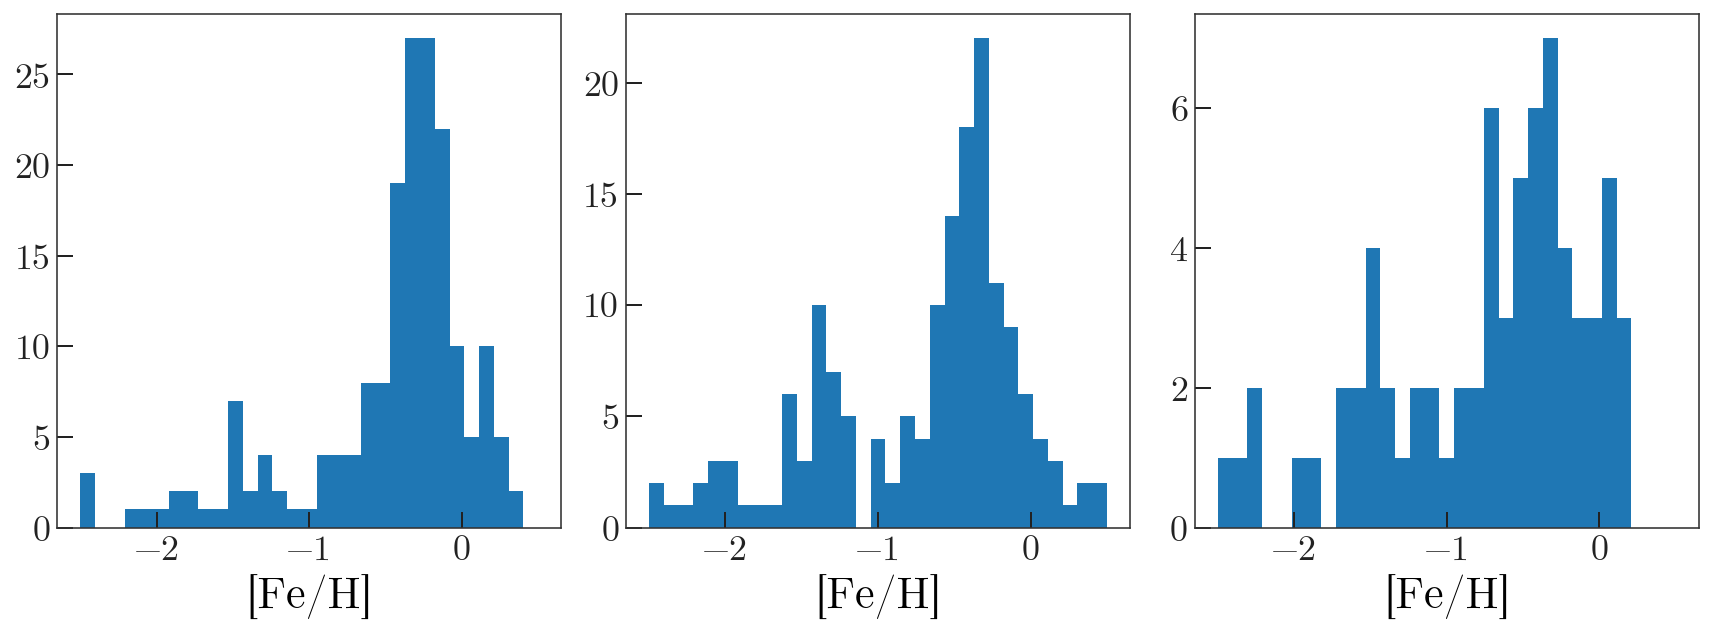

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex='row', sharey='row')
fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True)

for line in zip(range(3), 
                ['GD-1', 'Orp', 'Pal5'],
                [gd1_mask, orp_mask, pal5_mask],
                [gc.GD1(), gc.Orphan(), gc.Pal5()],
                [8.*u.kpc, 30*u.kpc, 22*u.kpc]):
    i, name, mask, frame, dist = line
    
    lon, lat, _ = frame.get_representation_component_names().keys()
    
    stream_g = g[mask]
    c = stream_g.get_skycoord(distance=dist, 
                              radial_velocity=np.array(stream_g.VHELIO_AVG)*u.km/u.s)
    c = gc.reflex_correct(c.transform_to(frame))
    pm1 = getattr(c, 'pm_{0}_cos{1}'.format(lon, lat)).to(u.mas/u.yr)
    pm2 = getattr(c, 'pm_{0}'.format(lat)).to(u.mas/u.yr)
    
    # top row
    ax = axes[0, i]
    ax.scatter(pm1, pm2,
               c=stream_g.FE_H, vmin=-2., vmax=0,
               marker='o', alpha=0.7, linewidth=0)
    if name == 'GD-1':
        ax.add_patch(mpl.patches.Polygon(pm_poly, facecolor='none', edgecolor='k', zorder=-10))
    ax.set_title(name)
    ax.axhline(0, zorder=-100, color='#cccccc')
    ax.set_xlabel('pm1')
    
    # bottom row
    ax = axes[1, i]
    ax.scatter(getattr(c, lon).wrap_at(180*u.deg),
               c.radial_velocity.to(u.km/u.s),
               c=stream_g.FE_H, vmin=-2., vmax=-1,
               marker='o', alpha=0.7, linewidth=0)
    ax.set_xlabel('phi1')
    
    # metallicity
    axes2[i].hist(stream_g.FE_H, bins=np.linspace(-2.5, 0.5, 32));
    axes2[i].set_xlabel('[Fe/H]')

fig.tight_layout()
axes[0, 0].set_xlim(-15, 15)
axes[0, 0].set_ylim(-15, 15)
axes[1, 0].set_xlim(-120, 60)
axes[1, 0].set_ylim(-300, 300)
axes[0, 0].set_ylabel('pm2')
axes[1, 0].set_ylabel('RV')

fig.tight_layout()
fig2.tight_layout()

---

In [13]:
kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [35]:
w = np.load('../../gd1-dr2/data/stream_model.npy')
stream_w = gd.PhaseSpacePosition(pos=w[:, :3].T*u.kpc,
                                 vel=w[:, 3:].T*u.km/u.s)
model_c = stream_w.to_coord_frame(gc.GD1)

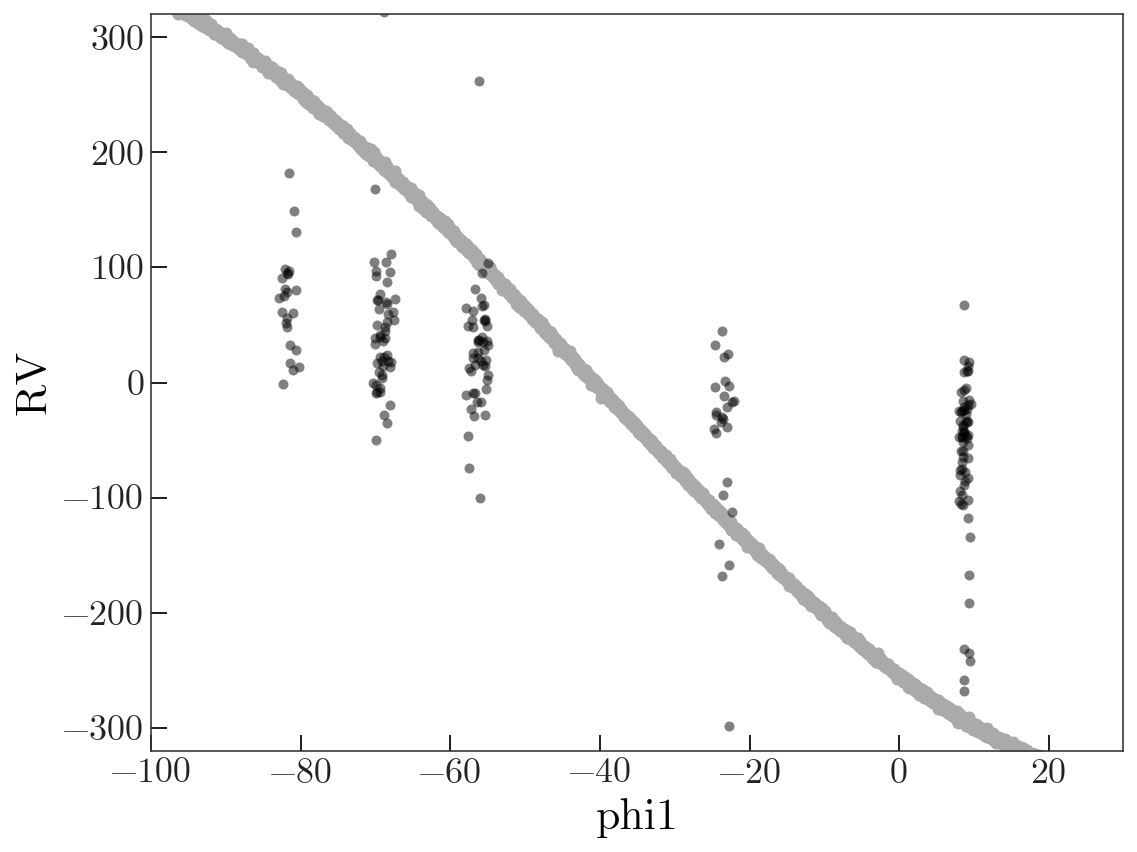

In [41]:
name = 'GD-1'
mask = gd1_mask
frame = gc.GD1()
dist = 10*u.kpc

stream_g = g[mask]
c = stream_g.get_skycoord(distance=dist, 
                          radial_velocity=np.array(stream_g.VHELIO_AVG)*u.km/u.s)
c = gc.reflex_correct(c.transform_to(frame))
pm1 = c.pm_phi1_cosphi2
pm2 = c.pm_phi2

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(c.phi1.wrap_at(180*u.deg),
           stream_g.VHELIO_AVG,
           c='k', marker='o', alpha=0.5, linewidth=0)
# ax.scatter(kop_vr['phi1'], kop_vr['vr'])#, kop_vr['err']

ax.scatter(model_c.phi1.wrap_at(180*u.deg),
           model_c.radial_velocity.to(u.km/u.s), 
           zorder=-100, color='#aaaaaa')

ax.set_xlabel('phi1')
ax.set_ylabel('RV')

ax.set_xlim(-100, 30)
ax.set_ylim(-320, 320)

fig.tight_layout()

In [43]:
phi1 = c.phi1.wrap_at(180*u.deg).degree
rv = stream_g.VHELIO_AVG
rv_mask = (((phi1 > 0) & (rv < -220) & (rv > -300)) | 
 ((phi1 < -20) & (phi1 > -40) & (rv < -95) & (rv > -200)) |
 ((phi1 > -60) & (phi1 < -50) & (rv > 90) & (rv < 150)))

In [51]:
feh_mask = (stream_g.FE_H > -1.9) & (stream_g.FE_H < -1.4)